In [1]:
using Distributions
using Images, Colors, FixedPointNumbers
using WAV
import Plots
Plots.plotlyjs()

Plots.PlotlyJSBackend()

In [2]:
include("../src/IncompleteCholesky.jl")
include("../src/Kernels.jl")
include("../src/preprocess.jl")
include("../src/FastICA.jl")
include("../src/KernelICA.jl")
include("../src/Amari.jl")

amari

**You will notice that most of the examples use Fast-ICA instead of Kernel-ICA when the interest is not directly  Kernel-ICA but ICA in general. While I tested everything with Kernel-ICA it is a very slow technique, especially in the easy to read version I have coded. I chose to use Fast-ICA when possible in this notebook so that you could run it.**

# A visual representation of ICA

In [3]:
u = Uniform(5,10)
s1, s2 = rand(u,Int64(1e4)), rand(u,Int64(1e4))
s = [s1 s2]

Plots.scatter(s[:,1],s[:,2],leg=false,border=false, markersize=0.8)

This is our original signal

In [4]:
A = [1 2; 21 20]
x = (A * s')
Plots.scatter(x[1,:],x[2,:],leg=false,border=false, markersize=0.8)

We now apply a linear transformation to our square.

In [5]:
xc , m = centeringt(x)
print("")

The first step is to center.

In [6]:
xw = whitent!(xc)
Plots.scatter(xw[1,:],xw[2,:],leg=false,border=false, markersize=0.8)

We then "whiten" the data, this is equivalent to "straightening" our observations using PCA.

In [7]:
w, s_ica = fastICA(xw, 2)
Plots.scatter(s_ica[1,:],s_ica[2,:],leg=false,border=false, markersize=0.8)

Once we have straightened our distributions we only need to find the optimal rotation.

# An example of misbehaved distribution

We will build a non normal distribution with zero skewness and zero excess kurtosis and try to see how the different ICA methods perform on it.

In [8]:
G = Gamma(2, 2)
N = Uniform(-0.5,0.5)
p = Bernoulli(0.5)
n = 3000
s = Matrix{Float64}(2,n)

2×3000 Array{Float64,2}:
 0.0           0.0           6.92838e-310  …  2.78134e-309  2.78134e-309
 6.92838e-310  6.92838e-310  6.92838e-310     6.92838e-310  6.92838e-310

In [65]:
for k = 1:2
    for i = 1:n
        if rand(p) == 0
            s[k,i] = rand(G)
        else
            s[k,i] = -rand(G)
        end
    end
end
print("S generated")

S generated

We are generating observations from the following distribution:

In [66]:
Plots.scatter(s[1,:],s[2,:],leg=false,border=false, markersize=0.8)

It has been built in such a way as to have $0$ excess kurtosis. Combined with other distributions (a gaussian for example) it would be an impossible distribution to separate for a lot of ICA algorithms based on cumulants. Kernel-ICA *should* work if the tolerance and kernel bandwidth are carefully chosen.

Let's now mix it!

In [67]:
A = [1 2; 21 20]

2×2 Array{Int64,2}:
  1   2
 21  20

In [68]:
x = A * s

Plots.scatter(x[1,:],x[2,:],leg=false,border=false, markersize=0.8)

In [69]:
x_c, m = centeringt(x)
x_w = whitent!(x_c)

Plots.scatter(x_w[1,:],x_w[2,:],leg=false,border=false, markersize=0.8)

## Fast-ICA

In [70]:
w_ica, s_ica = fastICA(x_w, 2)
print("Fast-ICA... Ok")

Fast-ICA... Ok

In [71]:
Plots.scatter(s_ica[1,:],s_ica[2,:],leg=false,border=false, markersize=0.8)

Clearly nothing has been separated.

## Kernel-ICA

In [72]:
w_kica, s_kica = kica(x_w)
print("Kernel-ICA... Ok")

Kernel-ICA... Ok

In [73]:
Plots.scatter(s_kica[1,:],s_kica[2,:],leg=false,border=false, markersize=0.8)

Seems to work much better!

# Comparing Kernel-ICA and Fast-ICA

In [17]:
d = MixtureModel(Normal[Normal(-1.0, 0.2), Normal(-0.2, 0.3), Normal(0.3, 0.2), Normal(1, 0.2)], [0.15, 0.45, 0.3, 0.1])

Plots.plot(x -> pdf(d,x),-2.5,2.5,leg=false,border=false)

In [26]:
p , n = 16, 5000
s = rand(d, (p,n))
print("Random Data")

Random Data

In [27]:
A = rand(Normal(1,10),(p,p))
print("Mixing Matrix")

Mixing Matrix

In [28]:
x = A * s
print("Mixed Observations")

Mixed Observations

In [29]:
x_c, m = centeringt(x)
x_w = whitent!(x_c)
print("Preprocessing")

Preprocessing

In [30]:
w_ica, s_ica = fastICA(x_w, p)
print("Fast-ICA... Ok")

Fast-ICA... Ok

In [31]:
w_kica, s_kica = kica(x_w)
print("Kernel-ICA... Ok")

Kernel-ICA... Ok

In [32]:
perf_fica = amari(A^(-1), w_ica)
perf_kica = amari(A^(-1), w_kica)
print("Performances de Fast-ICA: $perf_fica\nPerformances de Kernel-ICA: $perf_kica")

Performances de Fast-ICA: 4.882323159367039
Performances de Kernel-ICA: 5.220360902512415

# Image Unmixing

We will start by a simple example on images. Both Fast-ICA and Kernel-ICA works but I suggest only using Fast-ICA, or to be really patient and have a lot of memory.

We will mix three images and try to retrieve them.

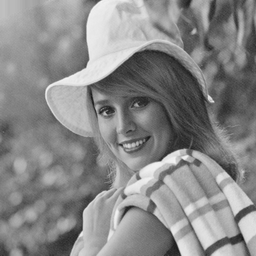

In [49]:
lena = load("../data/lena.tiff")
fabio = load("../data/fabio.tiff")
elaine = load("../data/elaine.tiff")

In [50]:
N = 256*256
slena = float(reshape(reinterpret(UInt8,data(lena)),N))
sfabio = float(reshape(reinterpret(UInt8,data(fabio)),N))
selaine = float(reshape(reinterpret(UInt8,data(elaine)),N))
print("Images converted to vectors")

Images converted to vectors

In [51]:
s = [slena sfabio selaine]'
print("We create our matrix of observations")

We create our matrix of observations

In [52]:
A = [1/2 1/4 1/4; 1/4 1/2 1/4; 1/4 1/4 1/2]
print("This will be our mixing matrix")

This will be our mixing matrix

In [53]:
x = A * s
print("And our mixed images")

And our mixed images

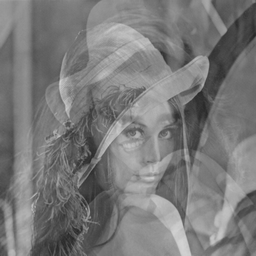

In [55]:
x_1 = reshape(x[1,:],(256,256))
x_1 = round(x_1)
x_1 = convert(Array{UInt8,2}, x_1)
imwrite(grayim(x_1),"../figures/mix1.png")
grayim(x_1)

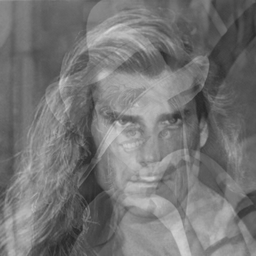

In [56]:
x_2 = reshape(x[2,:],(256,256))
x_2 = round(x_2)
x_2 = convert(Array{UInt8,2}, x_2)
imwrite(grayim(x_2),"../figures/mix2.png")
grayim(x_2)

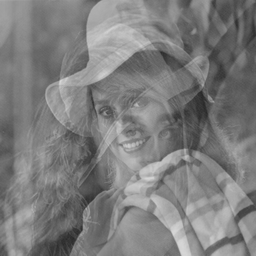

In [57]:
x_3 = reshape(x[3,:],(256,256))
x_3 = round(x_3)
x_3 = convert(Array{UInt8,2}, x_3)
imwrite(grayim(x_3),"../figures/mix3.png")
grayim(x_3)

In [58]:
xc, m = centeringt(x)
print("Centering... OK")

Centering... OK

In [59]:
xw = whitent!(xc)
print("Whitening... OK")

Whitening... OK

In [61]:
w_ica, s_ica = fastICA(xw, 3)
print("FastICA... OK")

FastICA... OK

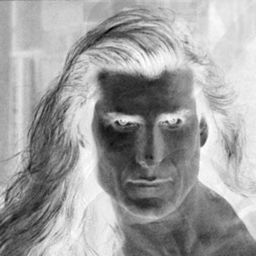

In [62]:
s_1 = reshape(s_ica[1,:],(256,256))
m1 = minimum(s_1)
M1 = maximum(s_1)
s_1 = (s_1 - m1) * 255/ (M1 - m1)
s_1 = round(s_1)
s_1 = convert(Array{UInt8,2}, s_1)
#imwrite(grayim(s_1),"../figures/s1.png")
grayim(s_1)

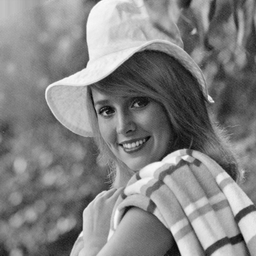

In [63]:
s_2 = reshape(s_ica[2,:],(256,256))
m1 = minimum(s_2)
M1 = maximum(s_2)
s_2 = (s_2 - m1) * 255/ (M1 - m1)
s_2 = round(s_2)
s_2 = convert(Array{UInt8,2}, s_2)
#imwrite(grayim(s_2),"../figures/s2.png")
grayim(s_2)

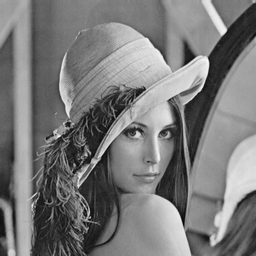

In [64]:
s_3 = reshape(s_ica[3,:],(256,256))
m1 = minimum(s_3)
M1 = maximum(s_3)
s_3 = (s_3 - m1) * 255/ (M1 - m1)
s_3 = round(s_3)
s_3 = convert(Array{UInt8,2}, s_3)
#imwrite(grayim(s_3),"../figures/s3.png")
grayim(s_3)

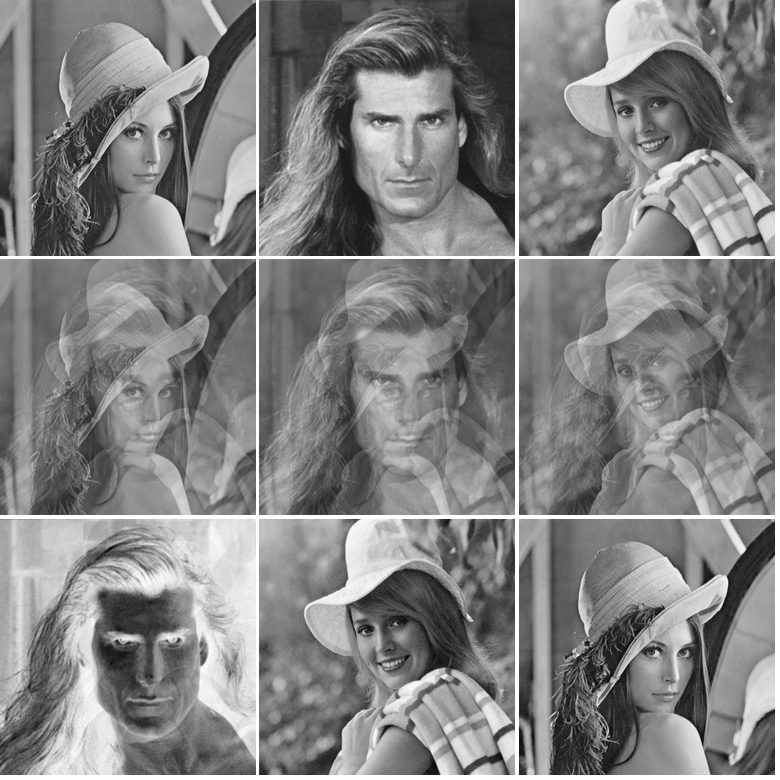

In [65]:
i1 = convert(Array{Int,2},reinterpret(UInt8,data(lena)))
i2 = convert(Array{Int,2},reinterpret(UInt8,data(fabio)))
i3 = convert(Array{Int,2},reinterpret(UInt8,data(elaine)))
i4 = convert(Array{Int,2},x_1)
i5 = convert(Array{Int,2},x_2)
i6 = convert(Array{Int,2},x_3)
i7 = convert(Array{Int,2},s_1)
i8 = convert(Array{Int,2},s_2)
i9 = convert(Array{Int,2},s_3)

imagemixing = 255*ones((768+3*4,768+3*4))
imagemixing[1:256,1:256] = i1
imagemixing[(256*1+4):(2*256+4-1),1:256] = i2
imagemixing[(256*2+4*2):(3*256+4*2-1),1:256] = i3

imagemixing[1:256,(256*1+4):(2*256+4-1)] = i4
imagemixing[(256*1+4):(2*256+4-1),(256*1+4):(2*256+4-1)] = i5
imagemixing[(256*2+4*2):(3*256+4*2-1),(256*1+4):(2*256+4-1)] = i6

imagemixing[1:256,(256*2+4*2):(3*256+4*2-1)] = i7
imagemixing[(256*1+4):(2*256+4-1),(256*2+4*2):(3*256+4*2-1)] = i8
imagemixing[(256*2+4*2):(3*256+4*2-1),(256*2+4*2):(3*256+4*2-1)] = i9

imagemixing = convert(Array{UInt8,2}, imagemixing)
imwrite(grayim(imagemixing),"../figures/imagemixing.png")
grayim(imagemixing)

In [ ]:
# BEWARE: IF YOU EXECUTE THIS COMMAND YOU PROBABLY ARE GOING TO BE WAITING FOR QUITE SOME TIME
w_kgv, s_kgv = kica(xw) # Uncomment only if you really are a patient person.
print("Kernel-ICA... OK")

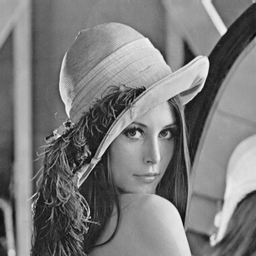

In [500]:
s_1 = reshape(s_kgv[:,1],(256,256))
m1 = minimum(s_1)
M1 = maximum(s_1)
s_1 = (s_1 - m1) * 255/ (M1 - m1)
s_1 = round(s_1)
s_1 = convert(Array{UInt8,2}, s_1)
imwrite(grayim(s_1),"../figures/s1_kernel.png")
grayim(s_1)

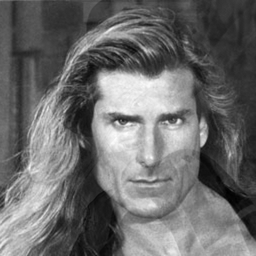

In [501]:
s_2 = reshape(s_kgv[:,2],(256,256))
m2 = minimum(s_2)
M2 = maximum(s_2)
s_2 = (s_2 - m2) * 255/ (M2 - m2)
s_2 = round(s_2)
s_2 = convert(Array{UInt8,2}, s_2)
imwrite(grayim(s_2),"../figures/s2_kernel.png")
grayim(s_2)

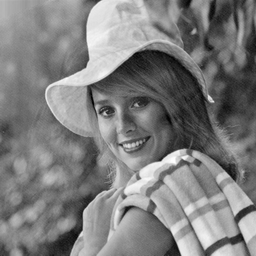

In [502]:
s_3 = reshape(s_kgv[:,3],(256,256))
m3 = minimum(s_3)
M3 = maximum(s_3)
s_3 = (s_3 - m3) * 255/ (M3 - m3)
s_3 = round(s_3)
s_3 = convert(Array{UInt8,2}, s_3)
imwrite(grayim(s_3),"../figures/s3_kernel.png")
grayim(s_3)

# ICA Basis

Here we change the problem. Instead $s$ the quantity of interest will now be $A$ (or $w$). We will decompose our images in patches and try to find natural basis of images. The columns of $A$ will form the independant basis of natural images with $s$ the realisations of the coefficients in this basis, while $w$ while form a basis of detectors. $w$ actually gives us the Gabor filters.

See:

Bell, A. J., & Sejnowski, T. J. (1997). Edges are the “Independent Components” of Natural Scenes. Vision Research, 37(23), 3327–3338. https://doi.org/10.1017/CBO9781107415324.004

In [66]:
img1 = load("../data/lena512.tiff")
img2 = load("../data/fabio512.tiff")
img3 = load("../data/elaine512.tiff")
f1 = float(reinterpret(UInt8,data(img1)))
f2 = float(reinterpret(UInt8,data(img2)))
f3 = float(reinterpret(UInt8,data(img3)))
print("Images Imported")

Images Imported

In [67]:
function random_patch(f, s)
    n = size(f,1)
    max = n - s
    x = rand(1:max)
    y = rand(1:max)
    return f[x:(x+s-1),y:(y+s-1)]
end

function random_patches(n, f, s)
    patches = zeros(n,s*s)
    for i = 1:n
        patch = random_patch(f, s)
        patches[i,:] = reshape(patch,s*s)
    end
    return patches
end

random_patches (generic function with 1 method)

In [68]:
samples = 20000
windows = zeros((3*samples,1024))
windows[1:samples,:] = random_patches(samples, f1, 32)
windows[(1+samples):(2*samples),:] = random_patches(samples, f2, 32)
windows[(1+2*samples):(3*samples),:] = random_patches(samples, f3, 32)
print("Random Patches Built...")

Random Patches Built...

In [69]:
size(windows)

(60000,1024)

In [70]:
windows_c, _ = centeringt(windows')
print("Centering... Ok")

Centering... Ok

In [71]:
size(windows_c)

(1024,60000)

In [72]:
windows_w  = whitent!(windows_c)
print("Whitening... Ok")

Whitening... Ok

In [73]:
w, coeffs = fastICA(windows_w, 64)
print("FastICA... Ok")

FastICA... Ok

In [74]:
size(w)

(64,1024)

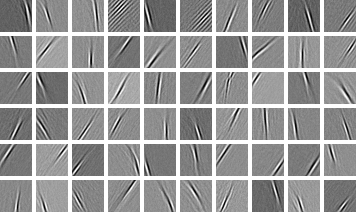

In [76]:
A = w
basis = 255*ones((320+9*4,192+5*4))
k = 1
for j = 1:6
    for i = 1:10
        temp = A[k,:]
        temp = reshape(temp,(32,32))
        m = minimum(temp)
        Ma = maximum(temp)
        temp = (temp - m) * 255/ (Ma - m)
        temp = round(temp)
        basis[(1+32*(i-1)+(i-1)*4):(32*i+(i-1)*4),(1+32*(j-1)+(j-1)*4):(32*j+(j-1)*4)] = temp
        k = k + 1
    end
end
basis = convert(Array{UInt8,2}, basis)
imwrite(grayim(basis),"../figures/basis.png")
grayim(basis)

# The cocktail party problem

The cockatil party problem is the canonical problem of ICA. While it is a cute example and I therefore give it here the "real" cocktail party problem is unsolveable with ICA only. ICA supposes instantaneous mixing while a real life recording will have a, albeit small but still non zero, delay between the recordings of the microphones. This is enough to make ICA impossible.

In this problem we wish to spy on $c$ different guests at a cocktail party. Unfortunately we cannot hear anything as everybody is speaking at the same time. We then set $m > c$ microphones to record the party. We then want to retrieve the original conversations.

In [3]:
s1, fs1 = wavread("../data/source1.wav")
s2, fs2 = wavread("../data/source2.wav")
s3, fs3 = wavread("../data/source1.wav")
print("WAVs imported")

WAVs imported

In [59]:
wavplay(s1, fs1)

In [62]:
wavplay(s2, fs2)

In [44]:
wavplay(s3, fs3)

In [4]:
s = [s1 s2 s3]'

3×50000 Array{Float64,2}:
 0.654902    0.513725    0.254902    …  0.0196078  0.027451   0.0823529
 0.00392157  0.00392157  0.00392157     0.0901961  0.0901961  0.0823529
 0.654902    0.513725    0.254902       0.0196078  0.027451   0.0823529

In [5]:
A = [1/2 1/4 1/4; 1/4 1/2 1/4; 1/4 1/4 1/2]

3×3 Array{Float64,2}:
 0.5   0.25  0.25
 0.25  0.5   0.25
 0.25  0.25  0.5 

In [6]:
x = A * s

3×50000 Array{Float64,2}:
 0.492157  0.386275  0.192157  0.309804  …  0.0372549  0.0431373  0.0823529
 0.329412  0.258824  0.129412  0.207843     0.054902   0.0588235  0.0823529
 0.492157  0.386275  0.192157  0.309804     0.0372549  0.0431373  0.0823529

In [68]:
wavplay(x[1,:], fs1)

In [7]:
wavplay(x[2,:], fs1)

In [70]:
wavplay(x[3,:], fs1)

In [71]:
x_c, m = centeringt(x)
x_w = whitent!(x_c)
print("Preprocessing... Done")

Preprocessing... Done

In [72]:
w_ica, s_ica = fastICA(x_w, 3)
print("FastICA... Done")

FastICA... Done

In [73]:
wavplay(s_ica[1,:], fs1)

In [74]:
wavplay(s_ica[2,:], fs1)

In [75]:
wavplay(s_ica[3,:], fs1)